In [2]:
# # srednio to działa w jupyter notebooku
# import subprocess
# def build_graph(path_to_jar, path_to_gtfs):
#     subprocess.call(['java', '-Xmx2G', '-jar', path_to_jar, '--build', '--save', path_to_gtfs])

# def serve_graph(path_to_jar, path_to_graph_parent_dir):
#     subprocess.call(['java', '-Xmx2G', '-jar', path_to_jar, '--load', '--serve', path_to_graph_parent_dir])

In [3]:
# path_to_jar = '../otp/otp-2.2.0-shaded.jar'
# path_to_graph = '../otp/otp_graphs/2023-05-18.gtfs/'
# serve_graph(path_to_jar, path_to_graph)

In [1]:
import requests
from typing import Optional, Dict

def get_response(query_parameters: Optional[Dict[str, str]] = None) -> requests.Response:
    if query_parameters is None:
        query_parameters = {
            "fromPlace": "52.19487631988541,21.024312973022464",
            "toPlace": "52.228272576254064,20.96903800964356",
            "time": "10:49am",
            "date": "05-18-2023",
            "mode": "TRANSIT,WALK",
            "arriveBy": "false",
            "wheelchair": "false",
            "showIntermediateStops": "true",
            "debugItineraryFilter": "false",
            "walkReluctance": "10",
            "additionalParameters": "walkReluctance",
            "locale": "pl",
            "numItineraries": "10",
        }

    url = "http://localhost:8080/otp/routers/default/plan?"

    for key, value in query_parameters.items():
        url += f"{key}={value}&"

    # Remove the trailing "&" at the end of the URL
    url = url.rstrip("&")

    response = requests.get(url)
    return query_parameters, response

In [4]:
import pandas as pd
query, response = get_response(None)
itineraries_df = pd.DataFrame(response.json()['plan']['itineraries'])

### mapa najczęściej odwiedzanych węzłów przystanków

In [25]:
import folium
import pandas as pd

tmp = pd.read_csv('../dane/gtfs-drive/2023-05-18.gtfs/stop_times.txt')
tmp['stop_id'] = tmp['stop_id'].str.strip()
stops = pd.read_csv('../dane/gtfs-drive/2023-05-18.gtfs/stops.txt')
tmp = tmp.merge(stops, 'inner', on='stop_id')
tmp['node'] = tmp['stop_id'].apply(lambda x: ''.join(x.split('_')[:-1]))
tmp = tmp.groupby('node').count().sort_values(ascending=False, by='trip_id').reset_index(drop=False).merge(tmp, how='left', on='node')
tmp.drop_duplicates(subset='node', inplace=True)

# Create a map centered around the specified coordinates
center_lat, center_lon = 52.23, 21.01
my_map = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Define a color scale based on the 'trip_id_x' values using StepColormap
color_scale = folium.StepColormap(['green', 'yellow', 'red'],
                                   index=tmp['trip_id_x'].quantile([0, 0.33, 0.66, 1]).values,
                                   caption='Count')

# Add the color scale to the map
my_map.add_child(color_scale)

# Function to map numeric values to named colors
def get_color(value):
    if value < 100:
        return 'green'
    elif value < 2000:
        return 'lightred'
    else:
        return 'red'

# Add markers for each data point with colors based on 'trip_id_x'
for index, row in tmp[:150].iterrows():
    color = get_color(row['trip_id_x'])
    folium.Marker([row['stop_lat_y'], row['stop_lon_y']],
                  popup=f"{''.join(row['stop_name_y'].split(' ')[:-1])} - Count: {row['trip_id_x']}",
                  icon=folium.Icon(color=color)).add_to(my_map)

# Save the map as an HTML file
my_map.save("../plots/EDA/stops_occupancy.html")


# benchmark przesiadek

In [26]:
# muzeum wilanów : 52.165201167925254, 21.09049767259721 *
# pałac królewski stare miasto : 52.248963845311124, 21.01529146366968 *
# francuska : 52.234521294640146, 21.053933021267078 * 
# arkadia : 52.2564580848624, 20.98385681963401
# lotnisko : 52.16466233177019, 20.969516668530133 * 
# mordor : 52.179312617041084, 21.003784302226087
# muzeum wódki : 52.255986733363315, 21.045979380575165
# muzeum powstania : 52.23374344918061, 20.981035021640107
# promenada : 52.23149250916612, 21.10963998004316
# pkin : 52.2319102250639, 21.006027190762005
# muzeum kopernika : 52.2418748527458, 21.028727101088748
# łazienki + belweder : 52.21321469405343, 21.027641805815158
# stadion narodowy : 52.23861443473494, 21.044607973740646
# wyścigi konne służew : 52.16066953299534, 21.013316804040734
# pole mokotowskie / politechnika : 52.212869749343454, 21.005889381059525
# sokowirówka wilanów : 52.15877563478556, 21.072135559952702
# powązki : 52.25279912233613, 20.981064442717255

# trasy wg rozkładu planowego

### serwer na grafie planowym

In [96]:
origins = ['52.234521294640146, 21.053933021267078', # francuska
            '52.248963845311124, 21.01529146366968', # stare miasto
            '52.179312617041084, 21.003784302226087', # mordor
            '52.2319102250639, 21.006027190762005', # pkin
            '52.15877563478556, 21.072135559952702', # sokowirówka wilanów
            '52.2418748527458, 21.028727101088748', # muzeum kopernika
            '52.25279912233613, 20.981064442717255', # powązki
            '52.23861443473494, 21.044607973740646', # stadion narodowy
            '52.15877563478556, 21.072135559952702', # łazienki
            '52.16466233177019, 20.969516668530133', # lotnisko chopina
            ]
destinations = ['52.165201167925254, 21.09049767259721', # muzeum wilanów
                '52.16466233177019, 20.969516668530133', # lotnisko chopina
                '52.23374344918061, 20.981035021640107', # muzeum powstania warszawskiego
                '52.16066953299534, 21.013316804040734', # tor konny służewiec
                '52.179312617041084, 21.003784302226087', # mordor
                '52.16066953299534, 21.013316804040734', # tor konny służewiec
                '52.23149250916612, 21.10963998004316', # promenada
                '52.16066953299534, 21.013316804040734', # tor konny służewiec
                '52.179312617041084, 21.003784302226087', # muzeum wódki
                '52.234521294640146, 21.053933021267078', # francuska
                ]
time = '08:00am'
date = '05-18-2023'
df = pd.DataFrame()
for src, dst in zip(origins, destinations):
    query_parameters = {
            "fromPlace": src,
            "toPlace": dst,
            "time": time,
            "date": date,
            "mode": "TRANSIT,WALK",
            "arriveBy": "true",
            "wheelchair": "false",
            "showIntermediateStops": "true",
            "debugItineraryFilter": "false",
            "walkReluctance": "10",
            "maxWalkDistance" : '1000',
            "additionalParameters": "walkReluctance, maxWalkDistance",
            "locale": "pl",
            "numItineraries": "10",
        }
    q, response = get_response(query_parameters)

    df = pd.concat([df, pd.json_normalize(response.json())], ignore_index=True)
df = df.drop(columns = ['previousPageCursor',
                        'nextPageCursor',
                        'elevationMetadata.ellipsoidToGeoidDifference',
                        'elevationMetadata.geoidElevation',
                        'requestParameters.maxWalkDistance',
                        'requestParameters.locale',
                        'requestParameters.walkReluctance',
                        'requestParameters.numItineraries',
                        'requestParameters.arriveBy',
                        'requestParameters.debugItineraryFilter',
                        'requestParameters.showIntermediateStops',
                        'requestParameters.wheelchair',
                        'requestParameters.fromPlace',
                        'requestParameters.mode',
                        'requestParameters.toPlace',
                        'requestParameters.additionalParameters',
                        'plan.date',
                        'plan.from.name',
                        'plan.from.vertexType',
                        'plan.to.name',
                        'plan.to.vertexType',
                        'metadata.searchWindowUsed',
                        'metadata.nextDateTime',
                        'metadata.prevDateTime',
                        'debugOutput.precalculationTime',	
                        'debugOutput.directStreetRouterTime',
                        'debugOutput.transitRouterTime',	
                        'debugOutput.filteringTime',	
                        'debugOutput.renderingTime',	
                        'debugOutput.totalTime',	
                        'debugOutput.transitRouterTimes.tripPatternFilterTime',
                        'debugOutput.transitRouterTimes.accessEgressTime',
                        'debugOutput.transitRouterTimes.raptorSearchTime',
                        'debugOutput.transitRouterTimes.itineraryCreationTime',
                        ]) 
# explode itineraries
df = df.explode('plan.itineraries').reset_index().rename(columns={'plan.itineraries' : 'itinerary'})
df.rename(columns={'index' : 'response_nr'}, inplace=True)
i = 0
itineraries = []
prev_row_resp_nr = -1
for _, row in df.iterrows():
    if row['response_nr'] == prev_row_resp_nr:
        i+=1
    else:
        i = 0
    itineraries.append(i)
    prev_row_resp_nr = row['response_nr']
itineraries
df['itinerary_nr'] = itineraries
print(df.shape)
df.head()

(19, 9)


,response_nr,requestParameters.date,requestParameters.time,plan.from.lon,plan.from.lat,plan.to.lon,plan.to.lat,itinerary,itinerary_nr
0,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,"{'duration': 3287, 'startTime': 1684390135000,...",0
1,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,"{'duration': 3263, 'startTime': 1684390195000,...",1
2,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,"{'duration': 3227, 'startTime': 1684390555000,...",2
3,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,"{'duration': 3287, 'startTime': 1684390735000,...",3
4,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,"{'duration': 3623, 'startTime': 1684390735000,...",4


In [28]:
# explode each itinerary
def explode_itineraries(df):
    df = df.explode('plan.itineraries').reset_index().rename(columns={'plan.itineraries' : 'itinerary'})
    df.rename(columns={'index' : 'response_nr'}, inplace=True)
    i = 0
    itineraries = []
    prev_row_resp_nr = -1
    for _, row in df.iterrows():
        if row['response_nr'] == prev_row_resp_nr:
            i+=1
        else:
            i = 0
        itineraries.append(i)
        prev_row_resp_nr = row['response_nr']
    itineraries
    df['itinerary_nr'] = itineraries

    tmp = pd.DataFrame()
    for _, row in df.iterrows():
        legs = pd.json_normalize(row['itinerary'])
        legs['response_nr'] = row['response_nr']
        legs['itinerary_nr'] = row['itinerary_nr']
        tmp = pd.concat([tmp, legs])
    itinerary_df = df.merge(tmp, on = ['response_nr', 'itinerary_nr'])
    itinerary_df.drop(columns=['itinerary', 'elevationGained', 'elevationLost', 'tooSloped', 'arrivedAtDestinationWithRentedBicycle'], inplace = True)

    itinerary_df['startTime'] = pd.to_datetime(itinerary_df['startTime'], unit='ms')
    itinerary_df['startTime'] = itinerary_df['startTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
    itinerary_df['endTime'] = pd.to_datetime(itinerary_df['endTime'], unit='ms')
    itinerary_df['endTime'] = itinerary_df['endTime'].dt.strftime('%Y-%m-%d %H:%M:%S')

    return(itinerary_df)

# rozkładanie na pojedyncze "legs"
def explode_legs(itinerary_df):
    tmp = pd.DataFrame()
    for num, row in itinerary_df.iterrows():
        leg = pd.json_normalize(row['legs'])
        leg['response_nr'] = row['response_nr']
        leg['itinerary_nr'] = row['itinerary_nr']
        leg['leg_nr'] = list(range(leg.shape[0]))
        leg['startTime'] = pd.to_datetime(leg['startTime'], unit='ms')
        leg['startTime'] = leg['startTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
        leg['endTime'] = pd.to_datetime(leg['endTime'], unit='ms')
        leg['endTime'] = leg['endTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
        leg = leg.rename(columns={'startTime' : 'legStartTime',
                                'endTime' : 'legEndTime'})
        tmp = pd.concat([tmp, leg])
    tmp
    legs_df = itinerary_df.merge(tmp, on = ['response_nr', 'itinerary_nr'])
    legs_df.drop('legs', axis = 1, inplace = True)
    return(legs_df)

def explode_intermediateStops(legs_df):
    tmp = pd.DataFrame()
    for num, row in legs_df.iterrows():
        if not isinstance(row['intermediateStops'],list):
            continue
        stops = pd.json_normalize(row['intermediateStops'])
        stops['response_nr'] = row['response_nr']
        stops['itinerary_nr'] = row['itinerary_nr']
        stops['leg_nr'] = row['leg_nr']
        stops['intermediate_stop_nr'] = list(range(stops.shape[0]))
        tmp = pd.concat([tmp, stops])
    stops_df = legs_df.merge(tmp, on = ['response_nr', 'itinerary_nr', 'leg_nr'], how='left')
    return(stops_df)

In [128]:
# explode each itinerary
tmp = pd.DataFrame()
for num, row in df.iterrows():
    legs = pd.json_normalize(row['itinerary'])
    legs['response_nr'] = row['response_nr']
    legs['itinerary_nr'] = row['itinerary_nr']
    tmp = pd.concat([tmp, legs])
itinerary_df = df.merge(tmp, on = ['response_nr', 'itinerary_nr'])
itinerary_df.drop(columns=['itinerary', 'elevationGained', 'elevationLost', 'tooSloped', 'arrivedAtDestinationWithRentedBicycle'], inplace = True)

itinerary_df['startTime'] = pd.to_datetime(itinerary_df['startTime'], unit='ms')
itinerary_df['startTime'] = itinerary_df['startTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
itinerary_df['endTime'] = pd.to_datetime(itinerary_df['endTime'], unit='ms')
itinerary_df['endTime'] = itinerary_df['endTime'].dt.strftime('%Y-%m-%d %H:%M:%S')

itinerary_df.head()

,response_nr,requestParameters.date,requestParameters.time,plan.from.lon,plan.from.lat,plan.to.lon,plan.to.lat,itinerary_nr,duration,startTime,endTime,walkTime,transitTime,waitingTime,walkDistance,walkLimitExceeded,generalizedCost,transfers,legs
0,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,0,3287,1684390135000,1684393422000,1187,2100,0,1298.19,False,12470,0,"[{'startTime': 1684390135000, 'endTime': 16843..."
1,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,1,3263,1684390195000,1684393458000,983,2040,240,998.04,False,10889,1,"[{'startTime': 1684390195000, 'endTime': 16843..."
2,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,2,3227,1684390555000,1684393782000,1187,1920,120,1298.19,False,13010,1,"[{'startTime': 1684390555000, 'endTime': 16843..."
3,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,3,3287,1684390735000,1684394022000,1187,2100,0,1298.19,False,12470,0,"[{'startTime': 1684390735000, 'endTime': 16843..."
4,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,4,3623,1684390735000,1684394358000,1133,2040,450,1165.92,False,12377,1,"[{'startTime': 1684390735000, 'endTime': 16843..."


In [123]:
# rozkładanie na pojedyncze "legs"
tmp = pd.DataFrame()
for num, row in itinerary_df.iterrows():
    leg = pd.json_normalize(row['legs'])
    leg['response_nr'] = row['response_nr']
    leg['itinerary_nr'] = row['itinerary_nr']
    leg['leg_nr'] = list(range(leg.shape[0]))
    leg['startTime'] = pd.to_datetime(leg['startTime'], unit='ms')
    leg['startTime'] = leg['startTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
    leg['endTime'] = pd.to_datetime(leg['endTime'], unit='ms')
    leg['endTime'] = leg['endTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
    leg = leg.rename(columns={'startTime' : 'legStartTime',
                              'endTime' : 'legEndTime'})
    tmp = pd.concat([tmp, leg])
tmp
legs_df = itinerary_df.merge(tmp, on = ['response_nr', 'itinerary_nr'])
legs_df.drop('legs', axis = 1, inplace = True)
legs_df.head()

,response_nr,requestParameters.date,requestParameters.time,plan.from.lon,plan.from.lat,plan.to.lon,plan.to.lat,itinerary_nr,duration_x,startTime_x,...,intermediateStops,routeShortName,routeLongName,from.stopId,from.arrival,from.stopIndex,from.stopSequence,to.stopIndex,to.stopSequence,leg_nr
0,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,0,3287,1684390135000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,0,3287,1684390135000,...,"[{'name': 'Królowej Marysieńki 02', 'stopId': ...",116,Chomiczówka,1:3044_02,1.684391e+12,1.0,2.0,23.0,26.0,1
2,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,0,3287,1684390135000,...,NaN,NaN,NaN,1:7048_02,1.684393e+12,NaN,NaN,NaN,NaN,2
3,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,1,3263,1684390195000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,1,3263,1684390195000,...,"[{'name': 'Królowej Marysieńki 02', 'stopId': ...",164,Wilanów,1:3044_02,1.684391e+12,11.0,14.0,16.0,20.0,1


In [149]:
tmp = pd.DataFrame()
for num, row in legs_df.iterrows():
    if not isinstance(row['intermediateStops'],list):
        continue
    stops = pd.json_normalize(row['intermediateStops'])
    stops['response_nr'] = row['response_nr']
    stops['itinerary_nr'] = row['itinerary_nr']
    stops['leg_nr'] = row['leg_nr']
    stops['intermediate_stop_nr'] = list(range(stops.shape[0]))
    tmp = pd.concat([tmp, stops])
stops_df = legs_df.merge(tmp, on = ['response_nr', 'itinerary_nr', 'leg_nr'], how='left')
stops_df.head()

,response_nr,requestParameters.date,requestParameters.time,plan.from.lon,plan.from.lat,plan.to.lon,plan.to.lat,itinerary_nr,duration_x,startTime_x,...,name,stopId,lon,lat,arrival,departure,stopIndex,stopSequence,vertexType,intermediate_stop_nr
0,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,0,3287,1684390135000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,0,3287,1684390135000,...,Królowej Marysieńki 02,1:3043_02,21.074621,52.168408,1.684391e+12,1.684391e+12,2.0,3.0,TRANSIT,0.0
2,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,0,3287,1684390135000,...,Sobieskiego 04,1:3042_04,21.067980,52.170350,1.684391e+12,1.684391e+12,3.0,4.0,TRANSIT,1.0
3,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,0,3287,1684390135000,...,Instytut Neurologii 52,1:3036_52,21.066260,52.171810,1.684391e+12,1.684391e+12,4.0,5.0,TRANSIT,2.0
4,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,0,3287,1684390135000,...,Truskawiecka 52,1:3034_52,21.058290,52.179360,1.684391e+12,1.684391e+12,5.0,7.0,TRANSIT,3.0


# trasy wg rozkładu rzeczywistego

### serwer na grafie rzeczywistym

In [185]:
time = '08:00am'
date = '05-18-2023'
rt_df = pd.DataFrame()
for src, dst in zip(origins, destinations):
    query_parameters = {
            "fromPlace": src,
            "toPlace": dst,
            "time": time,
            "date": date,
            "mode": "TRANSIT,WALK",
            "arriveBy": "True",
            "wheelchair": "false",
            "showIntermediateStops": "true",
            "debugItineraryFilter": "false",
            "walkReluctance": "10",
            "maxWalkDistance" : '1000',
            "additionalParameters": "walkReluctance, maxWalkDistance",
            "locale": "pl",
            "numItineraries": "10",
        }
    q, response = get_response(query_parameters)

    rt_df = pd.concat([rt_df, pd.json_normalize(response.json())], ignore_index=True)
rt_df = rt_df.drop(columns = ['previousPageCursor',
                        'nextPageCursor',
                        'elevationMetadata.ellipsoidToGeoidDifference',
                        'elevationMetadata.geoidElevation',
                        'requestParameters.maxWalkDistance',
                        'requestParameters.locale',
                        'requestParameters.walkReluctance',
                        'requestParameters.numItineraries',
                        'requestParameters.arriveBy',
                        'requestParameters.debugItineraryFilter',
                        'requestParameters.showIntermediateStops',
                        'requestParameters.wheelchair',
                        'requestParameters.fromPlace',
                        'requestParameters.mode',
                        'requestParameters.toPlace',
                        'requestParameters.additionalParameters',
                        'plan.date',
                        'plan.from.name',
                        'plan.from.vertexType',
                        'plan.to.name',
                        'plan.to.vertexType',
                        'metadata.searchWindowUsed',
                        'metadata.nextDateTime',
                        'metadata.prevDateTime',
                        'debugOutput.precalculationTime',	
                        'debugOutput.directStreetRouterTime',
                        'debugOutput.transitRouterTime',	
                        'debugOutput.filteringTime',	
                        'debugOutput.renderingTime',	
                        'debugOutput.totalTime',	
                        'debugOutput.transitRouterTimes.tripPatternFilterTime',
                        'debugOutput.transitRouterTimes.accessEgressTime',
                        'debugOutput.transitRouterTimes.raptorSearchTime',
                        'debugOutput.transitRouterTimes.itineraryCreationTime',
                        ]) 
# explode itineraries
rt_df = rt_df.explode('plan.itineraries').reset_index().rename(columns={'plan.itineraries' : 'itinerary'})
rt_df.rename(columns={'index' : 'response_nr'}, inplace=True)
i = 0
itineraries = []
prev_row_resp_nr = -1
for _, row in rt_df.iterrows():
    if row['response_nr'] == prev_row_resp_nr:
        i+=1
    else:
        i = 0
    itineraries.append(i)
    prev_row_resp_nr = row['response_nr']
rt_df['itinerary_nr'] = itineraries
print(rt_df.shape)
rt_df.head()

(20, 9)


,response_nr,requestParameters.date,requestParameters.time,plan.from.lon,plan.from.lat,plan.to.lon,plan.to.lat,itinerary,itinerary_nr
0,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,"{'duration': 3877, 'startTime': 1684389630000,...",0
1,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,"{'duration': 3914, 'startTime': 1684389630000,...",1
2,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,"{'duration': 4112, 'startTime': 1684389630000,...",2
3,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,"{'duration': 3965, 'startTime': 1684389777000,...",3
4,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,"{'duration': 4182, 'startTime': 1684389777000,...",4


In [186]:
# explode each itinerary
tmp = pd.DataFrame()
for num, row in rt_df.iterrows():
    legs = pd.json_normalize(row['itinerary'])
    legs['response_nr'] = row['response_nr']
    legs['itinerary_nr'] = row['itinerary_nr']
    tmp = pd.concat([tmp, legs])
rt_itinerary_df = rt_df.merge(tmp, on = ['response_nr', 'itinerary_nr'])
rt_itinerary_df.drop(columns=['itinerary', 'elevationGained', 'elevationLost', 'tooSloped', 'arrivedAtDestinationWithRentedBicycle'], inplace = True)


# # # Convert to human-readable time format
rt_itinerary_df['startTime'] = pd.to_datetime(rt_itinerary_df['startTime'], unit='ms')
rt_itinerary_df['startTime'] = rt_itinerary_df['startTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
rt_itinerary_df['endTime'] = pd.to_datetime(rt_itinerary_df['endTime'], unit='ms')
rt_itinerary_df['endTime'] = rt_itinerary_df['endTime'].dt.strftime('%Y-%m-%d %H:%M:%S')

rt_itinerary_df.head()

,response_nr,requestParameters.date,requestParameters.time,plan.from.lon,plan.from.lat,plan.to.lon,plan.to.lat,itinerary_nr,duration,startTime,endTime,walkTime,transitTime,waitingTime,walkDistance,walkLimitExceeded,generalizedCost,transfers,legs
0,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,0,3877,2023-05-18 06:00:30,2023-05-18 07:05:07,1318,2394,165,1355.31,False,13875,1,"[{'startTime': 1684389630000, 'endTime': 16843..."
1,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,1,3914,2023-05-18 06:00:30,2023-05-18 07:05:44,1187,2501,226,1298.19,False,13697,1,"[{'startTime': 1684389630000, 'endTime': 16843..."
2,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,2,4112,2023-05-18 06:00:30,2023-05-18 07:09:02,1133,2400,579,1165.92,False,12866,1,"[{'startTime': 1684389630000, 'endTime': 16843..."
3,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,3,3965,2023-05-18 06:02:57,2023-05-18 07:09:02,1430,1920,615,1585.86,False,15564,1,"[{'startTime': 1684389777000, 'endTime': 16843..."
4,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,4,4182,2023-05-18 06:02:57,2023-05-18 07:12:39,1634,2548,0,1886.01,False,17337,0,"[{'startTime': 1684389777000, 'endTime': 16843..."


In [187]:
# rozkładanie na pojedyncze "legs"
tmp = pd.DataFrame()
for num, row in rt_itinerary_df.iterrows():
    leg = pd.json_normalize(row['legs'])
    leg['response_nr'] = row['response_nr']
    leg['itinerary_nr'] = row['itinerary_nr']
    leg['startTime'] = pd.to_datetime(leg['startTime'], unit='ms')
    leg['startTime'] = leg['startTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
    leg['endTime'] = pd.to_datetime(leg['endTime'], unit='ms')
    leg['endTime'] = leg['endTime'].dt.strftime('%Y-%m-%d %H:%M:%S')
    leg = leg.rename(columns={'startTime' : 'legStartTime',
                              'endTime' : 'legEndTime'})
    leg['leg_nr'] = list(range(leg.shape[0]))
    tmp = pd.concat([tmp, leg])
tmp
rt_legs_df = rt_itinerary_df.merge(tmp, on = ['response_nr', 'itinerary_nr'])
rt_legs_df.drop('legs', axis = 1, inplace = True)
rt_legs_df.head()

,response_nr,requestParameters.date,requestParameters.time,plan.from.lon,plan.from.lat,plan.to.lon,plan.to.lat,itinerary_nr,duration_x,startTime,...,intermediateStops,routeShortName,routeLongName,from.stopId,from.arrival,from.stopIndex,from.stopSequence,to.stopIndex,to.stopSequence,leg_nr
0,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,0,3877,2023-05-18 06:00:30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,0,3877,2023-05-18 06:00:30,...,"[{'name': 'Królowej Marysieńki 02', 'stopId': ...",E-2,Metro Ratusz-Arsenał,1:3044_02,1.684390e+12,1.0,3.0,12.0,16.0,1
2,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,0,3877,2023-05-18 06:00:30,...,"[{'name': 'Ordynacka 02', 'stopId': '1:7049_02...",503,Natolin Płn.,1:7042_02,1.684392e+12,17.0,18.0,20.0,21.0,2
3,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,0,3877,2023-05-18 06:00:30,...,NaN,NaN,NaN,1:7046_02,1.684393e+12,NaN,NaN,NaN,NaN,3
4,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,1,3914,2023-05-18 06:00:30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [162]:
from math import isnan
tmp = pd.DataFrame()
for num, row in legs_df.iterrows():
    if not isinstance(row['intermediateStops'],list):
        continue
    stops = pd.json_normalize(row['intermediateStops'])
    stops['response_nr'] = row['response_nr']
    stops['itinerary_nr'] = row['itinerary_nr']
    stops['leg_nr'] = row['leg_nr']
    stops['intermediate_stop_nr'] = list(range(stops.shape[0]))
    tmp = pd.concat([tmp, stops])
rt_stops_df = rt_legs_df.merge(tmp, on = ['response_nr', 'itinerary_nr', 'leg_nr'], how='left')
rt_stops_df.head()

,response_nr,requestParameters.date,requestParameters.time,plan.from.lon,plan.from.lat,plan.to.lon,plan.to.lat,itinerary_nr,duration_x,startTime_x,...,name,stopId,lon,lat,arrival,departure,stopIndex,stopSequence,vertexType,intermediate_stop_nr
0,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,0,3877,1684389630000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,0,3877,1684389630000,...,Królowej Marysieńki 02,1:3043_02,21.074621,52.168408,1.684391e+12,1.684391e+12,2.0,3.0,TRANSIT,0.0
2,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,0,3877,1684389630000,...,Sobieskiego 04,1:3042_04,21.067980,52.170350,1.684391e+12,1.684391e+12,3.0,4.0,TRANSIT,1.0
3,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,0,3877,1684389630000,...,Instytut Neurologii 52,1:3036_52,21.066260,52.171810,1.684391e+12,1.684391e+12,4.0,5.0,TRANSIT,2.0
4,0,05-18-2023,08:00am,21.090498,52.165201,21.015292,52.248964,0,3877,1684389630000,...,Truskawiecka 52,1:3034_52,21.058290,52.179360,1.684391e+12,1.684391e+12,5.0,7.0,TRANSIT,3.0


# sprawdzenie braków danych w danym dniu

rt not found for day: 2022-03-22
rt not found for day: 2022-03-23
rt not found for day: 2022-03-24
no gtfs found
no gtfs found
rt not found for day: 2022-05-18
rt not found for day: 2022-09-02
no gtfs found
rt not found for day: 2023-04-28
rt not found for day: 2023-05-01
rt not found for day: 2023-05-03
rt not found for day: 2023-05-28
rt not found for day: 2023-05-29


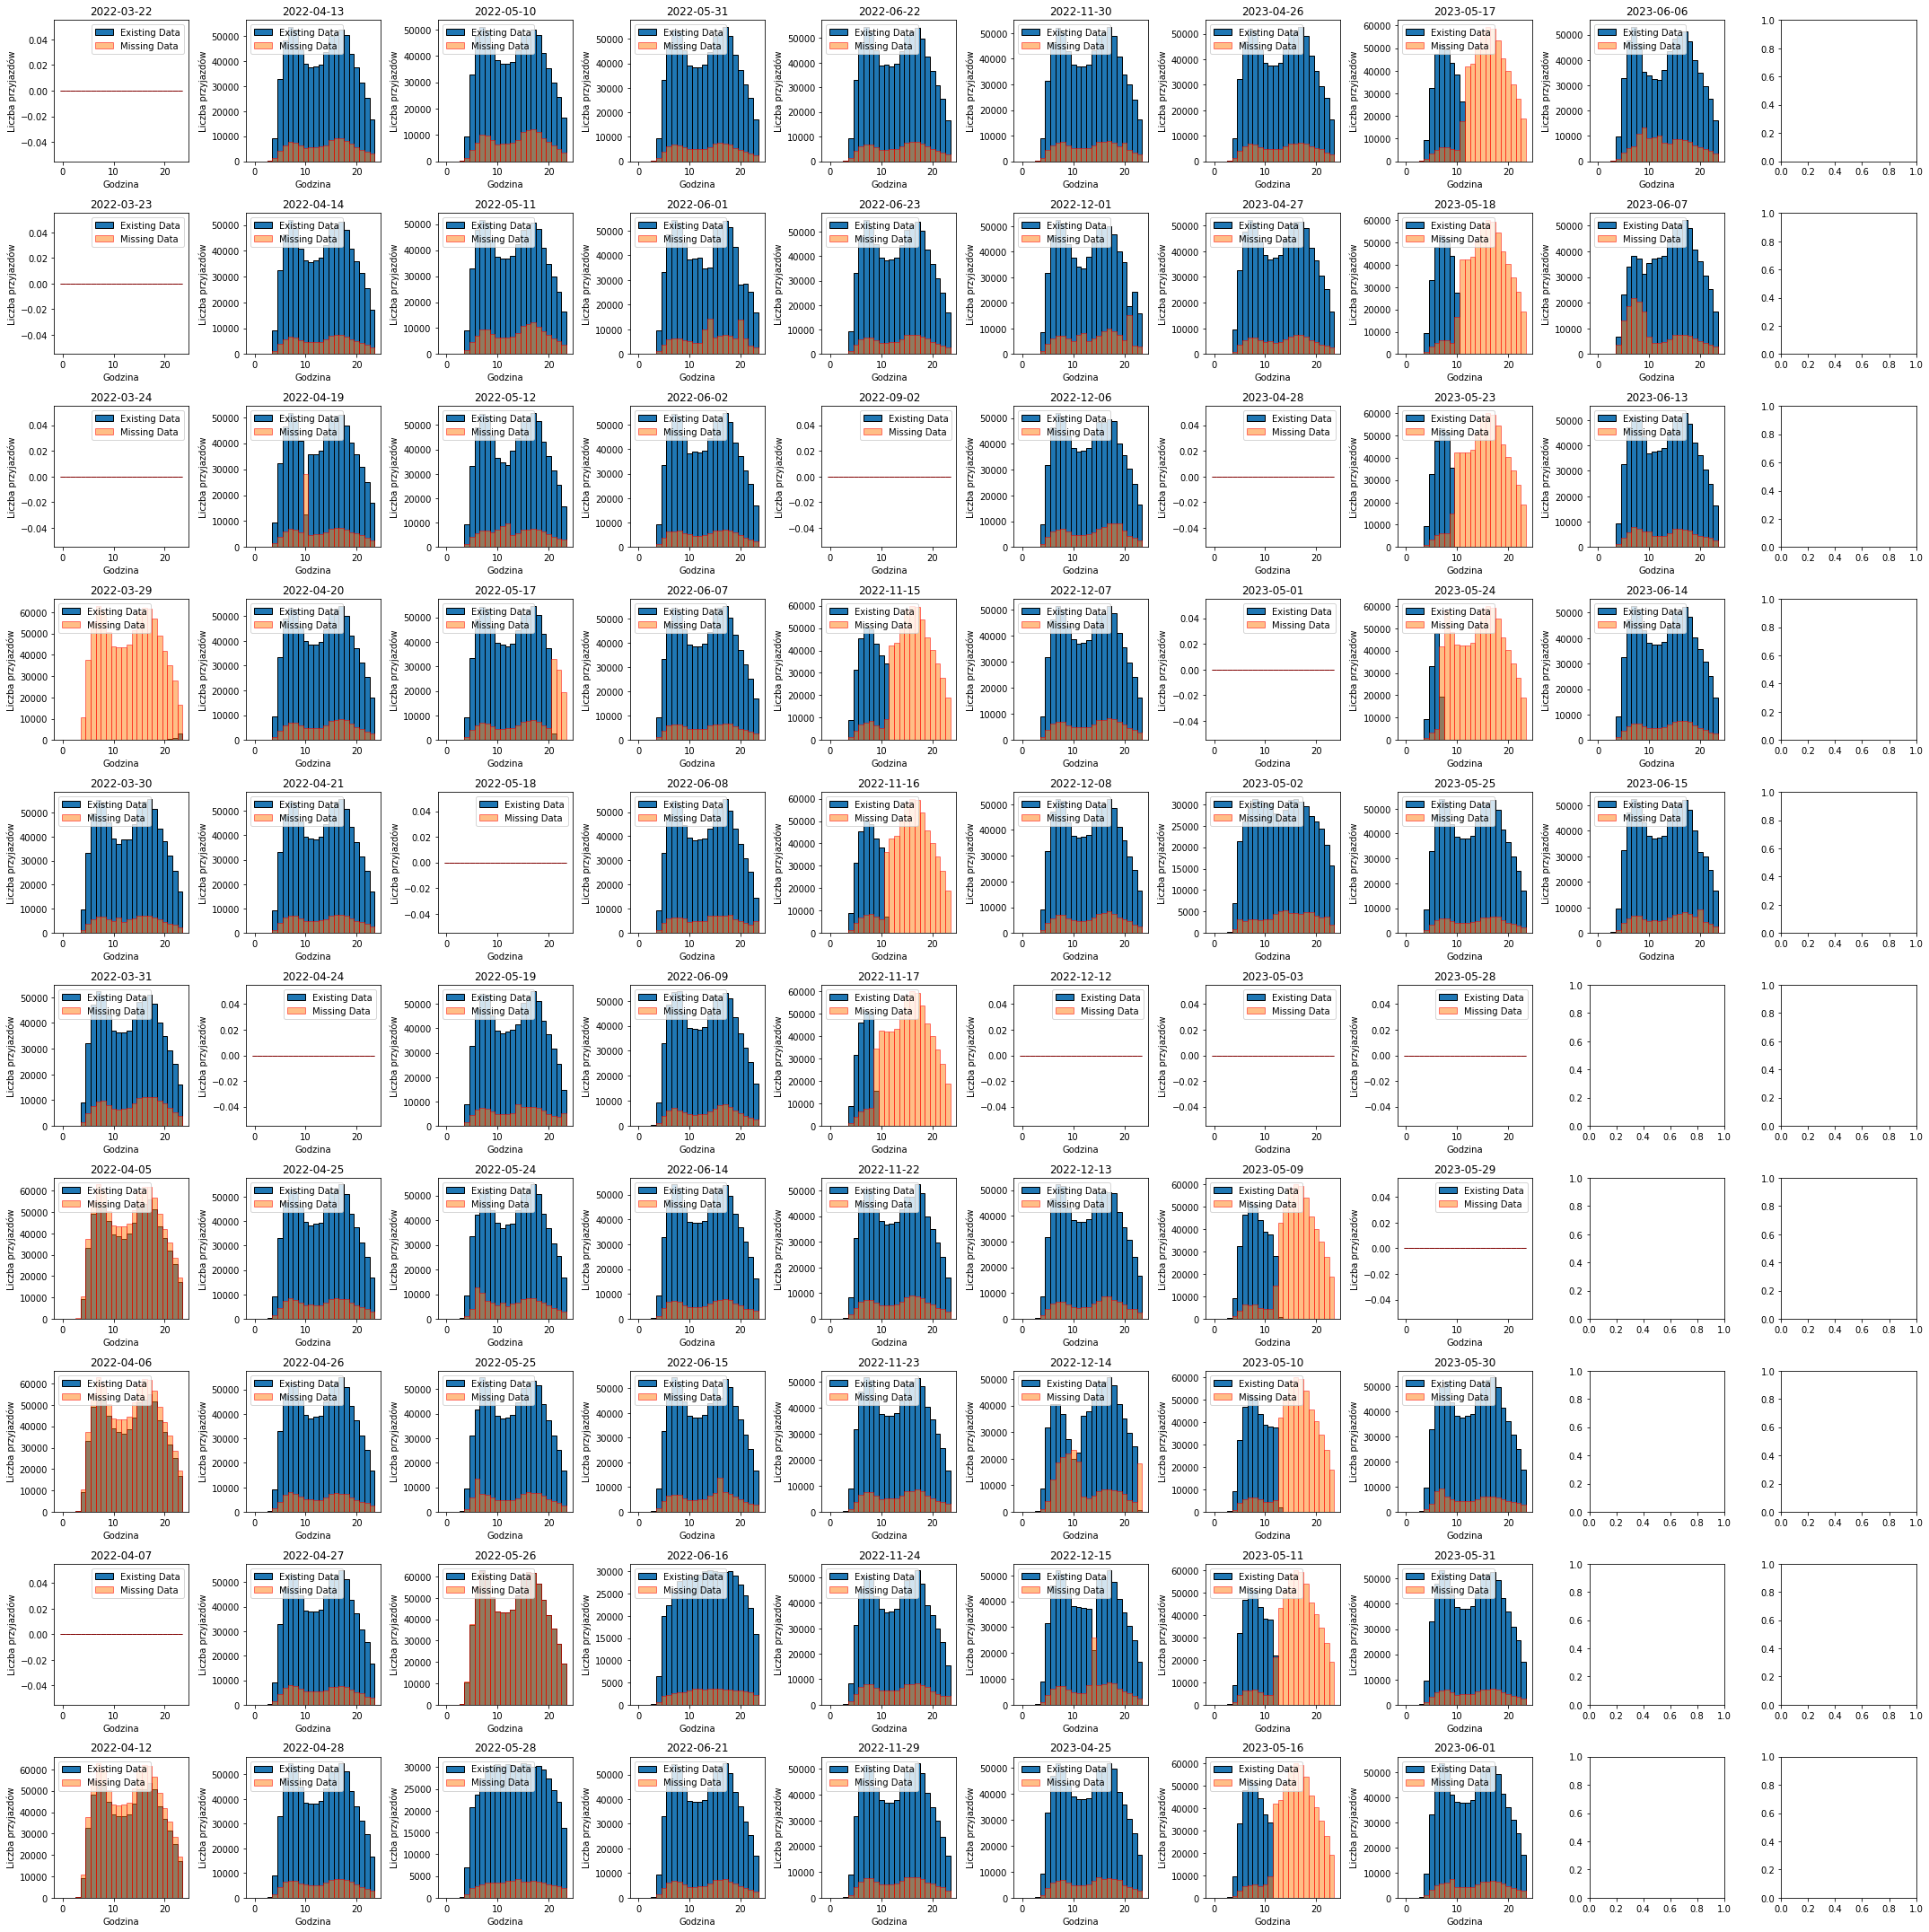

In [25]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
directory = "../dane/gtfs-drive/"



daty = os.listdir(directory)
daty = [data[:10] for data in daty]
daty = list(set(daty))
daty = sorted(daty)
daty = daty
fig, ax = plt.subplots(10,10)
fig.set_size_inches(30, 30)

for num, day in enumerate(daty):
    stop_times_columns = ['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence', 'date']    # dodatkowo data
    stop_times_df = pd.DataFrame(columns=stop_times_columns)

    routes_columns = ['route_id', 'agency_id', 'route_short_name', 'route_long_name', 'route_type']
    routes_df = pd.DataFrame(columns=routes_columns)

    trips_columns = ['route_id', 'service_id', 'trip_id', 'wheelchair_accessible']
    trips_df = pd.DataFrame(columns=trips_columns)

    rt_stop_times_columns = ['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence', 'date']    # dodatkowo data
    rt_stop_times_df = pd.DataFrame(columns=stop_times_columns)
    if  day+"-rt.gtfs" not in os.listdir(directory):
        print(f'rt not found for day: {day}')
    elif  day+".gtfs" not in os.listdir(directory):
        print(f'no gtfs found')
    else:
        filepath = directory + day

        filepath1 = filepath + ".gtfs"
        stop_times_tmp = pd.read_csv(filepath1 + '/stop_times.txt')
        stop_times_tmp['date'] = day
        routes_tmp = pd.read_csv(filepath1 + "/routes.txt")
        trips_tmp = pd.read_csv(filepath1 + "/trips.txt")

        filepath2 = filepath + "-rt.gtfs"
        rt_stop_times_tmp = pd.read_csv(filepath2 + "/stop_times.txt")
        rt_stop_times_tmp['date'] = day

        stop_times_df = pd.concat([stop_times_df, stop_times_tmp], ignore_index=True)
        routes_df = pd.concat([routes_df, routes_tmp], ignore_index=True)
        trips_df = pd.concat([trips_df, trips_tmp], ignore_index=True)
        rt_stop_times_df = pd.concat([rt_stop_times_df, rt_stop_times_tmp], ignore_index=True)

    tmp = pd.merge(stop_times_df, trips_df, on='trip_id')
    tmp = pd.merge(tmp, routes_df, on='route_id')
    # tmp = tmp[["trip_id", "stop_id", "route_id", "route_short_name", "date", "arrival_time"]]
    tmp = tmp[["trip_id", "stop_id", "route_id", "route_short_name", "arrival_time"]]

    final_missingval_merge = tmp.merge(rt_stop_times_df, on=['trip_id', 'stop_id'], how='outer')
    final_missingval_merge = final_missingval_merge.drop(['departure_time', 'stop_sequence'], axis=1)

    # Remove leading and trailing whitespaces using str.strip()
    final_missingval_merge['arrival_time_x'] = final_missingval_merge['arrival_time_x'].str.strip()
    final_missingval_merge['arrival_time_y'] = final_missingval_merge['arrival_time_y'].str.strip()

    final_missingval_merge['diff'] = pd.to_timedelta(final_missingval_merge['arrival_time_y'], errors='coerce') - pd.to_timedelta(final_missingval_merge['arrival_time_x'], errors='coerce')
    final_missingval_merge['diff'] = final_missingval_merge['diff'].apply(lambda x: pd.Timedelta.total_seconds(x) if pd.notna(x) else x)


    # Assuming you have a DataFrame named 'final_missingval_merge'

    # Convert 'arrival_time_y' to datetime
    final_missingval_merge['arrival_time_y'] = pd.to_datetime(final_missingval_merge['arrival_time_y'], format='%H:%M:%S', errors='coerce')

    # Extract hour from 'arrival_time_x' for missing data
    missing_data_hours = final_missingval_merge.loc[final_missingval_merge['arrival_time_y'].isna(), 'arrival_time_x']
    missing_data_hours = pd.to_datetime(missing_data_hours, format='%H:%M:%S', errors='coerce').dt.hour

    # Extract hour from 'arrival_time_y' for existing data
    existing_data_hours = final_missingval_merge['arrival_time_y'].dt.hour.dropna()

    # Create a histogram for existing data
    hist_existing, bin_edges = np.histogram(existing_data_hours, bins=24, range=(0, 24))

    # Create a histogram for missing data
    hist_missing, _ = np.histogram(missing_data_hours, bins=24, range=(0, 24))

    # Plotting
    ax[num%10, num//10].bar(bin_edges[:-1], hist_existing, width=1, edgecolor='black', label='Existing Data')
    ax[num%10, num//10].bar(bin_edges[:-1], hist_missing, width=1, edgecolor='red', alpha=0.5, label='Missing Data')

    ax[num%10, num//10].set_title(f'{day}')
    ax[num%10, num//10].set_xlabel('Godzina')
    ax[num%10, num//10].set_ylabel('Liczba przyjazdów')
    ax[num%10, num//10].legend()


# Save the figure
plt.tight_layout()
plt.savefig('../outputs/EDA/missing_data2.svg', format = 'svg', dpi = 300)

# Show the figure if needed
plt.show()

wielokrotnie powtarza się sytuacja, w której przestajemy zbierać dane w okolicach godziny 10:00

# file management

In [32]:
# moving files, zipping

import os
import zipfile
source_directory = "../dane/gtfs-drive/"
destination_directory = "../otp/otp_graphs/"
for directory in os.listdir(source_directory):

    directory_path = os.path.join(source_directory, directory)
    zip_file_path = "../otp/otp_graphs/" + directory + ".zip"
    with zipfile.ZipFile(zip_file_path, 'w') as zipf:
            # Iterate through the files in the current directory
            for root, _, files in os.walk(directory_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    # Add each file to the zip file 
                    zipf.write(file_path, os.path.relpath(file_path, directory_path))

os.listdir("../otp/otp_graphs/")

['2022-03-22.gtfs.zip',
 '2022-03-23.gtfs.zip',
 '2022-03-24.gtfs.zip',
 '2022-03-29-rt.gtfs.zip',
 '2022-03-29.gtfs.zip',
 '2022-03-30-rt.gtfs.zip',
 '2022-03-30.gtfs.zip',
 '2022-03-31-rt.gtfs.zip',
 '2022-03-31.gtfs.zip',
 '2022-04-05-rt.gtfs.zip',
 '2022-04-05.gtfs.zip',
 '2022-04-06-rt.gtfs.zip',
 '2022-04-06.gtfs.zip',
 '2022-04-07-rt.gtfs.zip',
 '2022-04-12-rt.gtfs.zip',
 '2022-04-12.gtfs.zip',
 '2022-04-13-rt.gtfs.zip',
 '2022-04-13.gtfs.zip',
 '2022-04-14-rt.gtfs.zip',
 '2022-04-14.gtfs.zip',
 '2022-04-19-rt.gtfs.zip',
 '2022-04-19.gtfs.zip',
 '2022-04-20-rt.gtfs.zip',
 '2022-04-20.gtfs.zip',
 '2022-04-21-rt.gtfs.zip',
 '2022-04-21.gtfs.zip',
 '2022-04-24-rt.gtfs.zip',
 '2022-04-25-rt.gtfs.zip',
 '2022-04-25.gtfs.zip',
 '2022-04-26-rt.gtfs.zip',
 '2022-04-26.gtfs.zip',
 '2022-04-27-rt.gtfs.zip',
 '2022-04-27.gtfs.zip',
 '2022-04-28-rt.gtfs.zip',
 '2022-04-28.gtfs.zip',
 '2022-05-10-rt.gtfs.zip',
 '2022-05-10.gtfs.zip',
 '2022-05-11-rt.gtfs.zip',
 '2022-05-11.gtfs.zip',
 '2022-

In [46]:
# moving more files
import shutil
src = "../otp/otp_graphs/"
zips = [x for x in os.listdir(src) if x.endswith('.zip')]
for zip in zips:
    dirname = zip[:-4]
    os.mkdir(src+dirname)
    shutil.move(src+zip, src+dirname+'/'+zip)
    shutil.copyfile('../otp/otp_graphs/2023-05-18.gtfs/build-config.json', src+dirname+'/build-config.json')
    shutil.copyfile('../otp/otp_graphs/2023-05-18.gtfs/otp-config.json', src+dirname+'/otp-config.json')
    shutil.copyfile('../otp/otp_graphs/2023-05-18.gtfs/router-config.json', src+dirname+'/router-config.json')
    shutil.copyfile('../otp/otp_graphs/2023-05-18.gtfs/streetGraph.obj', src+dirname+'/streetGraph.obj')

In [1]:
# building graphs
import subprocess
import os

jar_path = "D:\school\sem7\inzynierka\otp/otp-2.2.0-shaded.jar"
path = 'D:\school\sem7\inzynierka\otp\otp_graphs'
for dirpath in os.listdir(path):
    command = ["java", "-Xmx2G", "-jar", jar_path, "--loadStreet", "--save", path+'/'+dirpath]

    try:
        subprocess.run(command, check=True)
        print(f'{dirpath} done')
    except subprocess.CalledProcessError as e:
        print(f"Error: {e}") 

2022-03-22.gtfs done
2022-03-23.gtfs done
2022-03-24.gtfs done
Error: Command '['java', '-Xmx2G', '-jar', 'D:\\school\\sem7\\inzynierka\\otp/otp-2.2.0-shaded.jar', '--loadStreet', '--save', 'D:\\school\\sem7\\inzynierka\\otp\\otp_graphs/2022-03-29-rt.gtfs']' returned non-zero exit status 4294967295.
Error: Command '['java', '-Xmx2G', '-jar', 'D:\\school\\sem7\\inzynierka\\otp/otp-2.2.0-shaded.jar', '--loadStreet', '--save', 'D:\\school\\sem7\\inzynierka\\otp\\otp_graphs/2022-03-29.gtfs']' returned non-zero exit status 4294967295.
2022-03-30-rt.gtfs done
2022-03-30.gtfs done
2022-03-31-rt.gtfs done
2022-03-31.gtfs done
Error: Command '['java', '-Xmx2G', '-jar', 'D:\\school\\sem7\\inzynierka\\otp/otp-2.2.0-shaded.jar', '--loadStreet', '--save', 'D:\\school\\sem7\\inzynierka\\otp\\otp_graphs/2022-04-05-rt.gtfs']' returned non-zero exit status 4294967295.
2022-04-05.gtfs done
Error: Command '['java', '-Xmx2G', '-jar', 'D:\\school\\sem7\\inzynierka\\otp/otp-2.2.0-shaded.jar', '--loadStreet'

# set-up server, get responses

In [21]:
import subprocess
from time import sleep
from multiprocessing import Process
import pandas as pd
import signal
import os
import psutil

origins = ['52.234521294640146, 21.053933021267078', # francuska
            '52.248963845311124, 21.01529146366968', # stare miasto
            '52.179312617041084, 21.003784302226087', # mordor
            '52.2319102250639, 21.006027190762005', # pkin
            '52.15877563478556, 21.072135559952702', # sokowirówka wilanów
            '52.2418748527458, 21.028727101088748', # muzeum kopernika
            '52.25279912233613, 20.981064442717255', # powązki
            '52.23861443473494, 21.044607973740646', # stadion narodowy
            '52.15877563478556, 21.072135559952702', # łazienki
            '52.16466233177019, 20.969516668530133', # lotnisko chopina
            ]
destinations = ['52.165201167925254, 21.09049767259721', # muzeum wilanów
                '52.16466233177019, 20.969516668530133', # lotnisko chopina
                '52.23374344918061, 20.981035021640107', # muzeum powstania warszawskiego
                '52.16066953299534, 21.013316804040734', # tor konny służewiec
                '52.179312617041084, 21.003784302226087', # mordor
                '52.16066953299534, 21.013316804040734', # tor konny służewiec
                '52.23149250916612, 21.10963998004316', # promenada
                '52.16066953299534, 21.013316804040734', # tor konny służewiec
                '52.179312617041084, 21.003784302226087', # muzeum wódki
                '52.234521294640146, 21.053933021267078', # francuska
                ]
times = ['8:00am',
         '6:30am',
         '1:00pm',
         '3:30pm',
         '5:00pm',
         '11:30pm'
         ]


def start_server(path_to_jar, path_to_graph_parent_dir):
    command = ['java', '-Xmx2G', '-jar', path_to_jar, '--load', '--serve', path_to_graph_parent_dir]
    print(command)
    process = subprocess.Popen(command)
    return process

def stop_server(process):
    # Try to terminate the process gracefully
    try:
        process.terminate()
        process.wait()
    except Exception as e:
        print(f"Error while terminating the process: {e}")

    # Check if the process is still running
    if psutil.pid_exists(process.pid):
        # Forcefully kill the process
        try:
            parent = psutil.Process(process.pid)
            for child in parent.children(recursive=True):
                child.terminate()
            parent.terminate()
            parent.wait()
        except Exception as e:
            print(f"Error while forcefully terminating the process: {e}")
    process.kill()
    process.wait()
    print('server stopped')

# Example usage in Jupyter Notebook
path_to_jar = "../otp/otp-2.2.0-shaded.jar"
src = '../otp/otp_graphs'

# # Create a shared value to store the server process
# server_process = Process(target=run_server, args=(path_to_jar, path_to_graph_parent_dir,))

# # Start the server in a separate process
# server_process.start()
# Perform your iterations
df = pd.DataFrame()
rt_df = pd.DataFrame()

for date in [x for x in os.listdir(src) if not x.endswith('unpaired')]:

    directory = src+'/'+date
    for file in os.listdir(directory):
        if [True for x in os.listdir(directory + '/' + file) if x.endswith('graph.obj')]:

            path_to_graph_parent_dir = directory + '/' + file
            server_process = start_server(path_to_jar, path_to_graph_parent_dir)

            print(f'server started for {date}')
# Wait for a while to simulate the server running
            sleep(10)
            for origin, destination in zip(origins, destinations):
                for time in times:
                    query_parameters = {
                        "fromPlace": origin,
                        "toPlace": destination,
                        "time": time,
                        "date": date,
                        "mode": "TRANSIT,WALK",
                        "arriveBy": "true",
                        "wheelchair": "false",
                        "showIntermediateStops": "true",
                        "debugItineraryFilter": "false",
                        "maxWalkDistance" : '1000',
                        "additionalParameters": "maxWalkDistance",
                        "locale": "pl",
                        "numItineraries": "10",
                    }
                    try:
                        q, r = get_response(query_parameters)
                    except:
                        pass
                    print(f"first itinerary of response: Duration={r.json()['plan']['itineraries'][0]['duration']}, walkTime={r.json()['plan']['itineraries'][0]['walkTime']}")
                    # Stop the server
                    if file.endswith('-rt.gtfs'):
                        rt_df = pd.concat([df, pd.json_normalize(r.json())], ignore_index=True)
                    else:
                        df = pd.concat([df, pd.json_normalize(r.json())], ignore_index=True)
                    sleep(1)
            stop_server(server_process)
            sleep(3)
# Make sure to join the process to wait for it to finish

['java', '-Xmx2G', '-jar', '../otp/otp-2.2.0-shaded.jar', '--load', '--serve', '../otp/otp_graphs/2022-03-30/2022-03-30-rt.gtfs']
server started for 2022-03-30
first itinerary of response: Duration=2724, walkTime=1013
first itinerary of response: Duration=2913, walkTime=1013
first itinerary of response: Duration=3174, walkTime=700
first itinerary of response: Duration=2895, walkTime=1013
first itinerary of response: Duration=2953, walkTime=1013
first itinerary of response: Duration=2984, walkTime=1165
first itinerary of response: Duration=3849, walkTime=1638
first itinerary of response: Duration=3666, walkTime=1638
first itinerary of response: Duration=3834, walkTime=1638
first itinerary of response: Duration=4019, walkTime=1498
first itinerary of response: Duration=4096, walkTime=1638
first itinerary of response: Duration=3807, walkTime=1498
first itinerary of response: Duration=5592, walkTime=5592
first itinerary of response: Duration=5592, walkTime=5592
first itinerary of response: 

In [25]:
# drop_columns = ['previousPageCursor',
#                 'nextPageCursor',
#                 'elevationMetadata.ellipsoidToGeoidDifference',
#                 'elevationMetadata.geoidElevation',
#                 'requestParameters.maxWalkDistance',
#                 'requestParameters.locale',
#                 'requestParameters.numItineraries',
#                 'requestParameters.arriveBy',
#                 'requestParameters.debugItineraryFilter',
#                 'requestParameters.showIntermediateStops',
#                 'requestParameters.wheelchair',
#                 'requestParameters.fromPlace',
#                 'requestParameters.mode',
#                 'requestParameters.toPlace',
#                 'requestParameters.additionalParameters',
#                 'plan.date',
#                 'plan.from.name',
#                 'plan.from.vertexType',
#                 'plan.to.name',
#                 'plan.to.vertexType',
#                 'metadata.searchWindowUsed',
#                 'metadata.nextDateTime',
#                 'metadata.prevDateTime',
#                 'debugOutput.precalculationTime',	
#                 'debugOutput.directStreetRouterTime',
#                 'debugOutput.transitRouterTime',	
#                 'debugOutput.filteringTime',	
#                 'debugOutput.renderingTime',	
#                 'debugOutput.totalTime',	
#                 'debugOutput.transitRouterTimes.tripPatternFilterTime',
#                 'debugOutput.transitRouterTimes.accessEgressTime',
#                 'debugOutput.transitRouterTimes.raptorSearchTime',
#                 'debugOutput.transitRouterTimes.itineraryCreationTime',
#                 ]

# df = df.drop(columns = drop_columns)
# rt_df = rt_df.drop(columns=drop_columns)



df.to_csv('itineraries.csv', sep=';', index = False)
rt_df.to_csv('rt_itineraries.csv', sep=';', index = False)

In [26]:
tmp = pd.read_csv('itineraries.csv', sep=';')
tmp

,requestParameters.date,requestParameters.time,plan.from.lon,plan.from.lat,plan.to.lon,plan.to.lat,plan.itineraries
0,2022-03-30,8:00am,21.053933,52.234521,21.090498,52.165201,"[{'duration': 2606, 'startTime': 1648616872000..."
1,2022-03-30,6:30am,21.053933,52.234521,21.090498,52.165201,"[{'duration': 3001, 'startTime': 1648611592000..."
2,2022-03-30,1:00pm,21.053933,52.234521,21.090498,52.165201,"[{'duration': 3283, 'startTime': 1648634590000..."
3,2022-03-30,3:30pm,21.053933,52.234521,21.090498,52.165201,"[{'duration': 3001, 'startTime': 1648643992000..."
4,2022-03-30,5:00pm,21.053933,52.234521,21.090498,52.165201,"[{'duration': 3061, 'startTime': 1648648912000..."
...,...,...,...,...,...,...,...
4255,2023-06-15,6:30am,20.969517,52.164662,21.053933,52.234521,"[{'duration': 2882, 'startTime': 1686800147000..."
4256,2023-06-15,1:00pm,20.969517,52.164662,21.053933,52.234521,"[{'duration': 2790, 'startTime': 1686823967000..."
4257,2023-06-15,3:30pm,20.969517,52.164662,21.053933,52.234521,"[{'duration': 3194, 'startTime': 1686832427000..."
4258,2023-06-15,5:00pm,20.969517,52.164662,21.053933,52.234521,"[{'duration': 3314, 'startTime': 1686837707000..."


In [29]:
itineraries_df = explode_itineraries(df)
itineraries_df.head()

,response_nr,requestParameters.date,requestParameters.time,plan.from.lon,plan.from.lat,plan.to.lon,plan.to.lat,itinerary_nr,duration,startTime,endTime,walkTime,transitTime,waitingTime,walkDistance,walkLimitExceeded,generalizedCost,transfers,legs
0,0,2022-03-30,8:00am,21.053933,52.234521,21.090498,52.165201,0,2606,2022-03-30 05:07:52,2022-03-30 05:51:18,638,1560,408,763.47,False,4361,1,"[{'startTime': 1648616872000, 'endTime': 16486..."
1,0,2022-03-30,8:00am,21.053933,52.234521,21.090498,52.165201,1,3086,2022-03-30 04:53:52,2022-03-30 05:45:18,665,1980,441,761.77,False,6028,3,"[{'startTime': 1648616032000, 'endTime': 16486..."
2,0,2022-03-30,8:00am,21.053933,52.234521,21.090498,52.165201,2,2821,2022-03-30 04:51:52,2022-03-30 05:38:53,752,1860,209,906.78,False,4672,1,"[{'startTime': 1648615912000, 'endTime': 16486..."
3,0,2022-03-30,8:00am,21.053933,52.234521,21.090498,52.165201,3,4018,2022-03-30 04:44:20,2022-03-30 05:51:18,2578,1440,0,3155.22,False,6938,0,"[{'startTime': 1648615460000, 'endTime': 16486..."
4,0,2022-03-30,8:00am,21.053933,52.234521,21.090498,52.165201,4,2801,2022-03-30 04:42:37,2022-03-30 05:29:18,941,1740,120,1139.88,False,4816,1,"[{'startTime': 1648615357000, 'endTime': 16486..."


In [44]:
import numpy as np
ids = np.where(itineraries_df['duration'] == itineraries_df['walkTime'])
itineraries_df.drop(list(ids[0]), inplace=True)

In [45]:
legs_df = explode_legs(itineraries_df)
legs_df.head()

KeyboardInterrupt: 

In [ ]:
stops_df = explode_intermediateStops(legs_df)
stops_df.head()

# plot routes